In [19]:
from lxml import etree

In [20]:
root = etree.Element("root")

In [21]:
print(root.tag)

root


In [22]:
root.append(etree.Element('child1'))

In [23]:
child2 = etree.SubElement(root, "child2")
child3 = etree.SubElement(root, "child3")

In [24]:
print(etree.tostring(root, pretty_print=True).decode('utf-8'))

<root>
  <child1/>
  <child2/>
  <child3/>
</root>



In [25]:
child = root[0]
print(child.tag)

child1


In [26]:
print(len(root))

3


In [27]:
root.index(root[1])

1

In [29]:
children = list(root)
children

[<Element child1 at 0x1090995c8>,
 <Element child2 at 0x109099748>,
 <Element child3 at 0x109079f08>]

In [30]:
for child in root:
    print(child.tag)

child1
child2
child3


In [31]:
root.insert(0, etree.Element("child0"))

In [32]:
print(etree.tostring(root, pretty_print=True).decode('utf-8'))

<root>
  <child0/>
  <child1/>
  <child2/>
  <child3/>
</root>



In [33]:
start = root[:1]
end = root[-1:]
print(start[0].tag)
print(end[0].tag)

child0
child3


In [34]:
if root:   # this no longer works!
    print("The root element has children")

The root element has children


/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  """Entry point for launching an IPython kernel.


In [35]:
etree.iselement(root)

True

In [36]:
if len(root):
    print("The root element has children")

The root element has children


In [38]:
print(etree.tostring(root, pretty_print=True).decode('utf-8'))

root[0] = root[-1]

print(etree.tostring(root, pretty_print=True).decode('utf-8'))

<root>
  <child0/>
  <child1/>
  <child2/>
  <child3/>
</root>

<root>
  <child3/>
  <child1/>
  <child2/>
</root>



In [39]:
root is root[0].getparent()

True

In [40]:
from copy import deepcopy
element = etree.Element("neu")
element.append( deepcopy(root[1]) )
print(element[0].tag)
print([c.tag for c in root])

child1
['child3', 'child1', 'child2']


In [47]:
row = [1,2,3,4,5,6]
iterrow = iter(row)
[(i,j) for i,j in (iterrow(),iterrow())]

TypeError: 'list_iterator' object is not callable

In [48]:
print("str",1)

str 1


In [90]:
foldername = os.curdir
filename = 'test.xml'
imgSize = (800, 1000)


In [75]:
from lxml.etree import ElementTree, Element, SubElement
from lxml import etree

In [76]:
pointlist = [(1,2),
             (3,4),
             (5,6),
             (7,8),
             (9,10)]

In [77]:
top = Element('annotation')
for i, each_object in enumerate(pointlist):
    point = SubElement(top, "point"+str(i).zfill(3))
    X = SubElement(point,"X")
    X.text = str(each_object[0])
    Y = SubElement(point,"Y")
    Y.text = str(each_object[1])
print(etree.tostring(top, pretty_print=True).decode('utf-8'))

<annotation>
  <point000>
    <X>1</X>
    <Y>2</Y>
  </point000>
  <point001>
    <X>3</X>
    <Y>4</Y>
  </point001>
  <point002>
    <X>5</X>
    <Y>6</Y>
  </point002>
  <point003>
    <X>7</X>
    <Y>8</Y>
  </point003>
  <point004>
    <X>9</X>
    <Y>10</Y>
  </point004>
</annotation>



In [ ]:
for each_object in self.shapelist:
    object_item = SubElement(top, 'object')
    name = SubElement(object_item, 'name')
    try:
        name.text = unicode(each_object['name'])
    except NameError:
        # Py3: NameError: name 'unicode' is not defined
        name.text = each_object['name']

    pose = SubElement(object_item, 'pose')
    pose.text = "Unspecified"
    truncated = SubElement(object_item, 'truncated')
    if int(each_object['ymax']) == int(self.imgSize[0]) or (int(each_object['ymin'])== 1):
        truncated.text = "1" # max == height or min
    elif (int(each_object['xmax'])==int(self.imgSize[1])) or (int(each_object['xmin'])== 1):
        truncated.text = "1" # max == width or min
    else:
        truncated.text = "0"
    difficult = SubElement(object_item, 'difficult')
    difficult.text = str( bool(each_object['difficult']) & 1 )
    bndbox = SubElement(object_item, 'bndbox')
    xmin = SubElement(bndbox, 'xmin')
    xmin.text = str(each_object['xmin'])
    ymin = SubElement(bndbox, 'ymin')
    ymin.text = str(each_object['ymin'])
    xmax = SubElement(bndbox, 'xmax')
    xmax.text = str(each_object['xmax'])
    ymax = SubElement(bndbox, 'ymax')
    ymax.text = str(each_object['ymax'])

In [98]:
from PyQt5.QtGui import QImageReader

In [100]:
formats = ['*.%s' % fmt.data().decode("ascii").lower() for fmt in QImageReader.supportedImageFormats()]
formats

['*.bmp',
 '*.cur',
 '*.gif',
 '*.heic',
 '*.heif',
 '*.icns',
 '*.ico',
 '*.jp2',
 '*.jpeg',
 '*.jpg',
 '*.pbm',
 '*.pgm',
 '*.png',
 '*.ppm',
 '*.svg',
 '*.svgz',
 '*.tga',
 '*.tif',
 '*.tiff',
 '*.wbmp',
 '*.webp',
 '*.xbm',
 '*.xpm']

In [ ]:
class cache(object):
    def __init__(self, folderpath, filename, num = 1000):
        # 
        self.folder = path = os.path.dirname(ustr(self.filePath)) if self.filePath else '.'
        self.total
        pass

    def update(self):

    def openFile(self, _value=False):
        
        formats = ['*.%s' % fmt.data().decode("ascii").lower() for fmt in QImageReader.supportedImageFormats()]
        filters = "Image & Label files (%s)" % ' '.join(formats + ['*%s' % LabelFile.suffix])
        filename = QFileDialog.getOpenFileName(self, '%s - Choose Image or Label file' % __appname__, path, filters)
        if filename:
            if isinstance(filename, (tuple, list)):
                filename = filename[0]
            self.loadFile(filename)

    def prev(self, _value=False):
        # Proceding prev image without dialog if having any label
        if self.autoSaving.isChecked():
            if self.defaultSaveDir is not None:
                if self.dirty is True:
                    self.saveFile()
            else:
                self.changeSavedirDialog()
                return

        if not self.mayContinue():
            return

        if len(self.mImgList) <= 0:
            return

        if self.filePath is None:
            return

        currIndex = self.mImgList.index(self.filePath)
        if currIndex - 1 >= 0:
            filename = self.mImgList[currIndex - 1]
            if filename:
                self.loadFile(filename)

    def openNextImg(self, _value=False):
        # Proceding prev image without dialog if having any label
        if self.autoSaving.isChecked():
            if self.defaultSaveDir is not None:
                if self.dirty is True:
                    self.saveFile()
            else:
                self.changeSavedirDialog()
                return

        if not self.mayContinue():
            return

        if len(self.mImgList) <= 0:
            return

        filename = None
        if self.filePath is None:
            filename = self.mImgList[0]
        else:
            currIndex = self.mImgList.index(self.filePath)
            if currIndex + 1 < len(self.mImgList):
                filename = self.mImgList[currIndex + 1]

        if filename:
            self.loadFile(filename)

In [101]:
import math

In [103]:
math.floor(-0.1)

-1

In [105]:
from PyQt5.QtGui import QImage 

In [108]:
image = QImage()
image.load("/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0000.jpg")
image

In [111]:
alist = [1,2,3,4,5]

In [113]:
flag = alist.index(0)
flag

ValueError: 0 is not in list

In [194]:
from PyQt5.QtGui import QImage

In [195]:
filename = "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0000.jpg"
with open(filename, 'rb') as f:
    imageData = f.read()
image = QImage.fromData(imageData)

In [196]:
image.format()

4

In [199]:
image.Format_RGB32

4

In [135]:
image.width()

1072

In [136]:
image.height()

800

In [138]:
image.depth()

32

In [129]:
import qimage2ndarray
import numpy as np
import cv2
import matplotlib.pyplot as plt
# cv2.

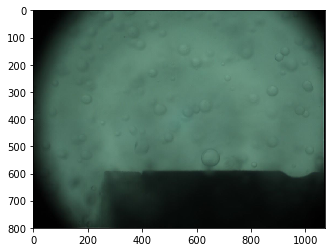

In [134]:
plt.imshow((qimage2ndarray.rgb_view(image)).reshape(800,1072,3))
plt.show()

In [222]:
import cv2

In [223]:
filename = "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0000.jpg"
cvimg = cv2.imread(filename)

In [221]:
cvimg.shape

(800, 1072, 3)

In [224]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
from PyQt5.QtCore import pyqtSignal
import numpy as np

# background subtraction and other preprossing procedure
FILENAME = "background.jpg"

class Preprocess:
    preprocessed = pyqtSignal()

    def __init__(self, dirname, length=10):
        if os.path.isdir(dirname):
            self.dirname = dirname
        else:
            return None
        self.imgPathList = glob.glob(os.path.join(self.dirname,'*.jpg'))
        tmp_img = cv2.imread(self.imgPathList[0])
        height, width, depth = tmp.img
        self.bg = np.zeros((height, width, depth))
        self.imgList = []
        self.length = length

    def __call__(self):
        img_path = os.path.join(self.dirname, FILENAME)
        # if we process it before and there exists backgrounnd image.
        if os.path.exists(img_path):
            self.bg = cv2.imread(img_path)
        else:
            self.imgPathList
            for index, f in enumerate(paths):
                if index >= self.length:
                    self.bg /= self.length
                    break
                img = cv2.imread(f)
                self.bg = np.add(self.bg, img)





NameError: name 'bgimg_gray' is not defined

In [ ]:
plt.imshow(bgimg_gray)

In [158]:
def qimage2numpyarray(image):
    height = image.height()
    width  = image.width()
    return (qimage2ndarray.rgb_view(image)).reshape(height, width, 3)

In [160]:
arr = qimage2numpyarray(image)
arr

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [191]:
def numpyarray2qimage(arr):
    # height = self.numpyarray.shape[1]
    # width  = self.numpyarray.shape[0]
    numpyarray = np.transpose(arr, (1,0,2))                                                                                                                                                                              
    return QImage(arr.tobytes(), 800, 1072,  6400, QImage.Format_RGB888)

In [192]:
qimage2numpyarray(numpyarray2qimage(arr))

ValueError: qimageview can only handle 8- or 32-bit QImages (format was 13)

In [ ]:
def getCurrent(self):
    if self.subtractBackGround:
        return self.numpyarray2qimage(\
                    np.subtract(self.qimage2numpyarray(self.data[self.cursor]) \
                    ,self.background))
    else:
        return self.data[self.cursor]

def qimage2numpyarray(self, imgdata):
    height = self.data[0].height()
    width  = self.data[0].width()
    return (qimage2ndarray.rgb_view(imgdata)).reshape(height, width, 3)

def numpyarray2qimage(self, numpyarray):
    # height = self.numpyarray.shape[1]
    # width  = self.numpyarray.shape[0]
    numpyarray = np.transpose(numpyarray, (1,0,2))                                                                                                                                                                              
    return QImage(numpyarray.tobytes(), numpyarray.shape[1], numpyarray.shape[0], QImage.Format_RGB888)


In [110]:
ims = []
cal = []
cal_gray = []
paths = glob.glob('data/600V350Q401/*.jpg')
step = 1
image = cv.imread(paths[0])
bgimg_gray = np.zeros((800, 1072))
# print(type(bgimg_gray))
# print(bgimg_gray.shape)
for index, f in zip(range(len(paths)-1), paths[::step]):
    if index >= step + 1000:
        bgimg_gray /= index
        break
    image = cv.imread(f)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    bgimg_gray = np.add(bgimg_gray, image_gray)
    
plt.imshow(bgimg_gray, cmap='gray')

SyntaxError: invalid syntax (<ipython-input-110-1175d475c7e0>, line 1)

In [157]:
from PyQt5.QtCore import QThread, pyqtSignal


In [ ]:
class BackendThread(QThread):
    
    update_cache = pyqtSignal(int)
    
    def run(self):
        

In [3]:
class LabelsList():
    def __init__(self, length):
        self.labelslist = [None for _ in range(length)]

    def __len__(self):
        return len(self.labelslist)

    def update(self,i, shapes):
        self.labelslist[i] = shapes
    
    def __getitem__(self, n):
        try:
            self.labelslist[n]
        except IndexError:
            return None
        else:
            return self.labelslist[n]

    def __setitem__(self, n, value):
        self.labelslist[n] = value
        
    def __delitem__(self, n):
        todelete = self.labelslist[n]
        self.labelslist[n] = None
        del(todelete)

In [4]:
ll = LabelsList(999)


In [5]:
ll[1] = 2

In [6]:
len(ll)

999

In [7]:
ll[1]

2

In [12]:
ll[98] is None

True

In [14]:
l = [1,2,3,4]

In [16]:
for i1, i2 in enumerate(l, start=1):
    print(i1, i2)

1 1
2 2
3 3
4 4


In [27]:
a = slice(0,5,1)
a.indices(4)

(0, 4, 1)

In [203]:
ls = [None for _ in range(20)]

In [6]:
ls1, ls[1] = ls[1], None
del ls1
len(ls)

20

In [7]:
class lsmanager:
    def __init__(self):
        self.ls = [1,2,3]
    def __delitem__(self, i):
        self.ls[i], tmp = None, self.ls[i]
        del tmp
    def __getitem__(self, i):
        return self.ls[i]
    def show(self,i):
        print(self[i])

In [8]:
ls = lsmanager()
ls

In [9]:
ls.show(1)

2


In [10]:
del ls[1]

In [11]:
ls.ls

[1, None, 3]

In [15]:
del(ls[2])

In [16]:
ls.ls

[1, None, None]

In [45]:
import sys


class _const:
    class ConstError(TypeError):
        pass
    class ConstCaseError(ConstError):
        pass
    
    def __setattr__(self, name, value):
        if name in self.__dict__.keys():
            raise(self.ConstError, "Can't change const. ")
        if not name.isupper():
            raise(ConstCaseError, \
               'const name "{}" is not all uppercase'.format(name))
        self.__dict__[name] = value

sys.modules["const"]=_const()



In [202]:
# sys.modules

In [47]:
import const

In [48]:
const.A = 1

In [49]:
const.A

1

In [53]:
from PyQt5.QtCore import QPointF
from PyQt5.QtGui import QColor

In [87]:
import os
# import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PyQt5.QtCore import pyqtSignal, QPointF, QThread

# background subtraction and other preprossing procedure
BACKGROUND_FILENAME = "background.jpg"

class PreprocessThread(QThread):

    def __init__(self, imgList, length=10, imread_format=cv2.IMREAD_GRAYSCALE):
        super(PreprocessThread, self).__init__()
        self.imgPathList = imgList
        self.backgroundFilePath = os.path.join(os.path.dirname(self.imgPathList[0]), BACKGROUND_FILENAME)
        self.background = None
        self.length = length
        self.imread_format = imread_format
        
        tmp_img = cv2.imread(self.imgPathList[0], self.imread_format)
        if len(tmp_img.shape) == 2:
            self.height, self.width, self.depth = *tmp_img.shape, 1
        elif len(tmp_img.shape) == 3:
            self.height, self.width, self.depth = tmp_img.shape

    def generateBackground(self):
        if self.depth == 1:
            background = np.zeros((self.height, self.width))
        elif self.detph == 3:
            background = np.zeros((self.height, self.width, self.depth))
        print("self.height, self.width, self.depth", self.height, self.width, self.depth)
        for index, f in zip(range(self.length), self.imgPathList):
            print("enter iter", index)
            img = cv2.imread(f, self.imread_format)
            background = np.add(background, img)
        background /= min(self.length, len(self.imgPathList))
        cv2.imwrite(self.backgroundFilePath,background)
        return background

    def run(self):
        print("enter run")
        if os.path.exists(self.backgroundFilePath):
            print("enter self.backgroundFilePath")
            self.background = cv2.imread(self.backgroundFilePath, self.imread_format)
            print(self.background, 1)
        if self.background is None:
            print(self.background, 2)
            self.background = self.generateBackground()
            print(self.background, 3)

    def __getitem__(self,i):
        ori = self.load_origin(i)
        result = self.backgroundSubtraction(ori)
        result = self.equalizeHist(result)
        return result

    def load_origin(self, i):
        return cv2.imread(self.imgPathList[i], self.imread_format)
    
    def backgroundSubtraction(self, img, beta = 0.85):
        background = self.background if self.background is not None else self.generateBackground()
        result = np.subtract(img, beta*self.background)
        result = abs(result)
        return result

    def equalizeHist(self, img):
        return cv2.equalizeHist(np.array(img, dtype=np.uint8))

In [103]:
imgList = [ "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0000.jpg",
           "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0001.jpg",
           "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0002.jpg",
           "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0003.jpg",
           "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0004.jpg",
           "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0005.jpg",
           "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0006.jpg",
           "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0007.jpg",
           "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0008.jpg",
           "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0009.jpg",
           "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0010.jpg"]

In [89]:
backend = PreprocessThread(imgList)

In [90]:
backend.start()

enter run
enter self.backgroundFilePath


In [91]:
backend[1]

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [1 1 1 ..., 0 0 0]
 [1 1 1 ..., 0 0 0]
 [1 1 1 ..., 0 0 0]] 1
self.height, self.width, self.depth 800 1072 1
enter iter 0
enter iter 1
enter iter 2
enter iter 3
enter iter 4
enter iter 5
enter iter 6
enter iter 7
enter iter 8
enter iter 9


array([[17, 17, 17, ...,  0,  0,  0],
       [17, 17, 17, ...,  0,  0,  0],
       [17, 17, 17, ...,  0,  0,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [92]:
type(backend[1])

numpy.ndarray

In [93]:
backend[1].min()

0

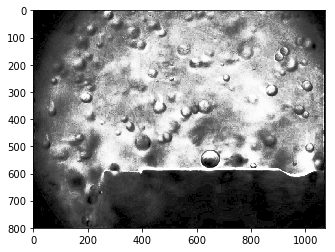

In [94]:
plt.imshow(backend[1],cmap='gray')
plt.show()

In [16]:
cv2.imshow("img",cv2.fromarray(backend[1]))

AttributeError: module 'cv2.cv2' has no attribute 'fromarray'

In [104]:
filename = "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0000.jpg"
os.path.basename(filename)

'420V10Q225_0000.jpg'

In [60]:
os.path.dirname(filename)

"/Volumes/Jerry's/zhouhan/420V5/420V10Q225"

In [ ]:
np.subtract()

In [96]:
import numpy as np
from PyQt5.QtGui import QImage
import cv2

[将np.array 转成 QImage 格式](https://www.aliyun.com/jiaocheng/433464.html?spm=5176.100033.2.9.34cb4d61JspVQl)


In [114]:
def ndarray2qimage(ndarray):
#     qimage = QImage()
    if len(ndarray.shape) == 2:
        height, width = ndarray.shape
    elif len(ndarray.shape) == 3:
        height, width, depth = ndarray.shape
    if ndarray.dtype == np.uint8:
        bytesPerComponent = 8
        bytesPerLine = bytesPerComponent * width
#     image = cv2.cvtColor(ndarray, cv2.COLOR_GRAY2RGB) 
    qimage = QImage(ndarray.data, width, height, bytesPerLine, QImage.Format_RGB888) 
    print(qimage)
    

def numpyarray2qimage(arr):
    # height = self.numpyarray.shape[1]
    # width  = self.numpyarray.shape[0]
    numpyarray = np.transpose(arr, (1,0,2))                                                                                                                                                                              
    return QImage(arr.tobytes(), 800, 1072,  6400, QImage.Format_RGB888)
#     class mycsms(QWidget, Ui_csms, Ui_MainWindow): 
# def __init__(self): 
# super(mycsms, self).__init__() 
# self.setupUi(self) 
# self.image = QImage() 
# self.device = cv2.VideoCapture(0) 
# self.playTimer = Timer("updatePlay()") 
# self.connect(self.playTimer, SIGNAL("updatePlay()"), self.showCamer) 
# # 读摄像头 
# def showCamer(self): 
# if self.device.isOpened(): 
# ret, frame = self.device.read() 
# else: 
# ret = False 
# # 读写磁盘方式 
# # cv2.imwrite("2.png", frame) 
# # self.image.load("2.png") 
# height, width, bytesPerComponent = frame.shape 
# bytesPerLine = bytesPerComponent * width 
# # 变换彩色空间顺序 
# cv2.cvtColor(frame, cv2.COLOR_BGR2RGB,frame) 
# # 转为QImage对象 
# self.image = QImage(frame.data, width, height, bytesPerLine, QImage.Format_RGB888) 
# self.view.setPixmap(QPixmap.fromImage(self.image))

In [115]:
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

In [116]:
ndarray2qimage(img)

In [ ]:
import os
os.remove()

In [ ]:
cv2.imwrite()

In [6]:
float("11a")

ValueError: could not convert string to float: '11a'

In [9]:
dct = dict()

In [17]:
dct.update({"1":2})
dct.update({"1":3})

In [18]:
dct

{'1': 3}

In [13]:
dct.update(dict(('1',2)))

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [24]:
import pandas as pd

In [33]:
df = pd.DataFrame(columns=['dir','subdir', 'img', 'index', 'radius'])

In [34]:
df.update([1,2,3,4,5])
df

,dir,subdir,img,index,radius


In [29]:
df.append([1,2,3,4,5])

/anaconda3/envs/dl/lib/python3.6/site-packages/pandas/core/indexes/api.py:77: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


,dir,subdir,img,index,radius,0
0,NaN,NaN,NaN,NaN,NaN,1.0
1,NaN,NaN,NaN,NaN,NaN,2.0
2,NaN,NaN,NaN,NaN,NaN,3.0
3,NaN,NaN,NaN,NaN,NaN,4.0
4,NaN,NaN,NaN,NaN,NaN,5.0


In [47]:
df = df.append([{'dir':1,'subdir':2, 'img':3, 'index':4, 'radius':5}], ignore_index=True)
df

,dir,subdir,img,index,radius
0,1,2,3,4,5
1,1,2,3,4,5
2,1,2,3,4,5
3,1,2,3,4,5
4,1,2,3,4,5
5,1,2,3,4,5


In [50]:
df['radius'].mean()

5.0

In [58]:
values, bins = np.histogram(df['radius'])
bins = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]
bins

[(4.5, 4.5999999999999996),
 (4.5999999999999996, 4.7000000000000002),
 (4.7000000000000002, 4.7999999999999998),
 (4.7999999999999998, 4.9000000000000004),
 (4.9000000000000004, 5.0),
 (5.0, 5.0999999999999996),
 (5.0999999999999996, 5.2000000000000002),
 (5.2000000000000002, 5.2999999999999998),
 (5.2999999999999998, 5.4000000000000004),
 (5.4000000000000004, 5.5)]

In [64]:
distribution= ''

In [65]:
for bin_, value in zip(bins, values):
    distribution += '({0[0]:.2f}, {0[0]:.2f}) : {1: d}\n'.format(bin_, value)

In [66]:
print(distribution)

(4.50, 4.50) :  0
(4.60, 4.60) :  0
(4.70, 4.70) :  0
(4.80, 4.80) :  0
(4.90, 4.90) :  0
(5.00, 5.00) :  6
(5.10, 5.10) :  0
(5.20, 5.20) :  0
(5.30, 5.30) :  0
(5.40, 5.40) :  0



In [10]:
import os

In [11]:
filename = "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/420V10Q225_0000.jpg"
os.path.basename(filename)

'420V10Q225_0000.jpg'

In [12]:
os.path.basename(os.path.dirname(filename))

'420V10Q225'

In [13]:
os.path.dirname(os.path.dirname(filename))

"/Volumes/Jerry's/zhouhan/420V5"

In [14]:
xmlfile = os.path.basename(filename)
subdir = os.path.basename(os.path.dirname(filename))
dir_ = os.path.dirname(os.path.dirname(filename))


In [16]:
os.path.join(xmlfile, subdir,dir_)

"/Volumes/Jerry's/zhouhan/420V5"

In [20]:
from math import sqrt

In [21]:
def getRadius(pts):
    def distance(p1, p2):
        x1, y1 = p1
        x2, y2 = p2
        return sqrt( (x2-x1)**2 + (y2-y1)**2 )
    p1, p2, p3, p4 = pts
    return sqrt(distance(p1, p2) * distance(p3, p4))

In [22]:
pts = [(0,0),
       (0,1),
       (1,2),
       (1,3)]

In [23]:
getRadius(pts)

1.0

In [104]:
lst = [1,2,3,4]
lst.index(1)

0

In [102]:
from PyQt5.QtCore import QPointF

In [71]:
csvfilename = "/Volumes/Jerry's/zhouhan/420V5/420V10Q225/track.csv"

In [68]:
import pandas as pd

In [81]:
df = pd.read_csv(csvfilename,encoding='utf-8')
df

,dir,subdir,imgfile,index,label,shapeType,points,difficult
0,/Volumes/Jerry's/zhouhan/420V5,420V10Q225,420V10Q225_0000.jpg,0,Broken 0,box,"[(556, 147), (877, 147), (877, 425), (556, 425)]",False
1,/Volumes/Jerry's/zhouhan/420V5,420V10Q225,420V10Q225_0000.jpg,1,Broken 1,ellipse,"[(162, 328), (234, 451), (275, 356), (145, 436)]",False
2,/Volumes/Jerry's/zhouhan/420V5,420V10Q225,420V10Q225_0001.jpg,3,Broken 3,box,"[(178, 234), (521, 234), (521, 496), (178, 496)]",False
3,/Volumes/Jerry's/zhouhan/420V5,420V10Q225,420V10Q225_0002.jpg,0,Broken 0,ellipse,"[(613, 310), (699, 407), (705, 317), (611, 407)]",False
4,/Volumes/Jerry's/zhouhan/420V5,420V10Q225,420V10Q225_0002.jpg,1,Broken 1,ellipse,"[(444, 510), (501, 654), (500, 578), (359, 623)]",False
5,/Volumes/Jerry's/zhouhan/420V5,420V10Q225,420V10Q225_0002.jpg,2,Broken 2,ellipse,"[(655, 470), (683, 572), (716, 499), (614, 510)]",False
6,/Volumes/Jerry's/zhouhan/420V5,420V10Q225,420V10Q225_0002.jpg,3,Broken 3,ellipse,"[(830, 206), (870, 300), (884, 222), (757, 271)]",False
7,/Volumes/Jerry's/zhouhan/420V5,420V10Q225,420V10Q225_0003.jpg,0,Broken 0,ellipse,"[(202, 441), (259, 539), (273, 462), (166, 512)]",False
8,/Volumes/Jerry's/zhouhan/420V5,420V10Q225,420V10Q225_0003.jpg,1,Broken 1,ellipse,"[(628, 531), (670, 579), (680, 530), (628, 573)]",False
9,/Volumes/Jerry's/zhouhan/420V5,420V10Q225,420V10Q225_0003.jpg,2,Broken 2,ellipse,"[(461, 322), (457, 369), (442, 344), (477, 347)]",False


In [90]:
bool(df.difficult[0])

False

"/Volumes/Jerry's/zhouhan/420V5"

In [101]:
dir_ = df.get_value(0,'dir')
subdir = df.get_value(0,'subdir')
dirPath = os.path.join(dir_, subdir)
for i, row in df.iterrows():
    imgfile = row.imgfile
    label = row.label
    shapeType = row.shapeType
    points = eval(row.points)
    difficult = bool(row.difficult)


In [84]:
type(df.difficult[0])

numpy.bool_

In [70]:
from PyQt5.QtGui import QPainterPath
from PyQt5.QtCore import QPoint

In [ ]:
path = QPainterPath(self.points[0])
for p in self.points[1:]:
    path.lineTo(p)

In [152]:
from collections import OrderedDict

In [168]:
d = OrderedDict()
d[1] = []
d[2] = []

In [171]:
OrderedDict[0]

TypeError: 'type' object is not subscriptable

In [170]:
d[3]

KeyError: 3

In [161]:
for i, j in d.items():
    print(i,j)

1 [1]
2 []


In [158]:
d[1].append(1)

In [159]:
d

OrderedDict([(1, [1]), (2, [])])

In [151]:
x=1
y=2
(x,y) in [(1,2)]

True

In [146]:
from collections import namedtuple
node = namedtuple("node",["i_img", "data"])
nodes = [node(0, 0), 
 node(1, 1),
 node(2, 2),
 node(2, 3),
 node(3, 4),
 node(3, 5),
 node(3, 6),
 node(4, 7),
 node(4, 8),
 node(4, 9),
 node(4, 10),
 node(4, 11),
 node(5, 12),
 node(6, 13)]



__main__.node

In [147]:
tree = Tree(1)

In [143]:
tree.addKid(tree.root, 2)
tree.addKid(tree.root, 3)

TypeError: isinstance() arg 2 must be a type or tuple of types

In [199]:
[i for i in filter(None,[None, None,None,None])]

[]

In [181]:
from functools import reduce
reduce(lambda x,y: x and y, [True, True, False])

In [ ]:
if reduce(lambda x,y: x or y, [Node(shape_obj) in  for shape_obj]):
                    continue

In [183]:
{"hello":"world", "say":"hi"}.get("hello")

'world'

In [182]:
reduce(lambda x,y: x and y, [True, True, False])

False

In [ ]:
import unittest

class TestStringMethods(unittest.TestCase):

    def test_upper(self):
        self.assertEqual('foo'.upper(), 'FOO')

    def test_isupper(self):
        self.assertTrue('FOO'.isupper())
        self.assertFalse('Foo'.isupper())

    def test_split(self):
        s = 'hello world'
        self.assertEqual(s.split(), ['hello', 'world'])
        # check that s.split fails when the separator is not a string
        with self.assertRaises(TypeError):
            s.split(2)

if __name__ == '__main__':
    unittest.main()

In [207]:
list(reversed([1,2,3,4]))

[4, 3, 2, 1]